# DQN

## Setup

### Initialization

In [1]:
import datetime
import logging
import shutil
from collections import deque, namedtuple, OrderedDict
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt

# import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import seaborn as sns
import ipdb

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# from torchinfo import summary

# if GPU is to be used
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cpu')

In [3]:
import plotting as viz

# from environment_lights_tensor import (
#     WrappedEnvironment,
#     Actions,
#     CONTEXTS_LABELS,
#     OdorCues,
#     LightCues,
# )
from agent_tensor import EpsilonGreedy
from environment_tensor import (
    CONTEXTS_LABELS,
    Actions,
    Cues,
    WrappedEnvironment,
    TriangleState,
)
import utils

In [4]:
# Formatting & autoreload stuff
%load_ext lab_black
%load_ext autoreload
%autoreload 2
# %matplotlib ipympl

### Parameters

In [5]:
p = utils.Params(
    # seed=42,
    # seed=123,
    n_runs=1,
    total_episodes=60,
    epsilon=0.5,
    alpha=1e-4,
    gamma=0.99,
    # n_hidden_units=(5 * 5 + 3) * 5,
    n_hidden_units=128,
    replay_buffer_max_size=5000,
    epsilon_min=0.2,
    epsilon_max=1.0,
    decay_rate=0.01,
    epsilon_warmup=100,
    batch_size=32,
    # target_net_update=200,
    tau=0.005,
    experiment_tag="scratch",
    layer_inspected=6 - 1,
)
p

Params(seed=None, n_runs=1, total_episodes=60, epsilon=0.5, epsilon_min=0.2, epsilon_max=1.0, decay_rate=0.01, epsilon_warmup=100, gamma=0.99, alpha=0.0001, nLayers=5, n_hidden_units=128, n_observations=None, n_actions=None, replay_buffer_max_size=5000, batch_size=32, target_net_update=100, tau=0.005, experiment_tag='scratch', layer_inspected=5)

In [6]:
if p.batch_size < 2:
    raise ValueError("The batch size needs to be more that one data point")

### Utilies

In [7]:
CURRENT_PATH = utils.create_save_path(p.experiment_tag)

Current path: /home/kir0ul/Projects/RL_Olfaction/TriangleTask/save/2024-05-01_20-34-23_scratch


In [8]:
LOGGER = utils.get_logger(current_path=CURRENT_PATH)

In [9]:
# Set the seed
GENERATOR = utils.make_deterministic(seed=p.seed)

### Environment definition

In [10]:
# Load the environment
env = WrappedEnvironment(one_hot_state=True, seed=p.seed)

In [11]:
# Get number of actions
# n_actions = env.action_space.n
p.n_actions = env.numActions

# Get the number of state observations
# state, info = env.reset()
state = env.reset()
p.n_observations = len(state)

print(f"Number of actions: {p.n_actions}")
print(f"Number of observations: {p.n_observations}")

Number of actions: 4
Number of observations: 28


### Network definition

In [12]:
ENCODER_NEURONS_NUM = 5


class DQN(nn.Module):
    def __init__(self, n_observations, n_actions, n_units=16):
        super(DQN, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(n_observations, n_units),
            nn.ReLU(),
            nn.Linear(n_units, n_units),
            nn.ReLU(),
            nn.Linear(n_units, ENCODER_NEURONS_NUM),
            nn.ReLU(),
            nn.Linear(ENCODER_NEURONS_NUM, n_units),
            nn.ReLU(),
            nn.Linear(n_units, n_units),
            nn.ReLU(),
            nn.Linear(n_units, n_actions),
            # nn.ReLU(),
        )

    def forward(self, x):
        return self.mlp(x)

In [13]:
def neural_network():
    # if env.one_hot_state:
    #     net = DQN(
    #         n_observations=p.n_observations,
    #         n_actions=p.n_actions,
    #         n_units=4 * p.n_observations,
    #     ).to(DEVICE)
    # else:
    #     net = DQN(
    #         n_observations=p.n_observations,
    #         n_actions=p.n_actions,
    #         n_units=p.n_hidden_units,
    #     ).to(DEVICE)
    # net

    net = DQN(
        n_observations=p.n_observations,
        n_actions=p.n_actions,
        n_units=p.n_hidden_units,
    ).to(DEVICE)

    target_net = DQN(
        n_observations=p.n_observations,
        n_actions=p.n_actions,
        n_units=p.n_hidden_units,
    ).to(DEVICE)

    target_net.load_state_dict(net.state_dict())

    return net, target_net

In [14]:
net, target_net = neural_network()
net, target_net

(DQN(
   (mlp): Sequential(
     (0): Linear(in_features=28, out_features=128, bias=True)
     (1): ReLU()
     (2): Linear(in_features=128, out_features=128, bias=True)
     (3): ReLU()
     (4): Linear(in_features=128, out_features=5, bias=True)
     (5): ReLU()
     (6): Linear(in_features=5, out_features=128, bias=True)
     (7): ReLU()
     (8): Linear(in_features=128, out_features=128, bias=True)
     (9): ReLU()
     (10): Linear(in_features=128, out_features=4, bias=True)
   )
 ),
 DQN(
   (mlp): Sequential(
     (0): Linear(in_features=28, out_features=128, bias=True)
     (1): ReLU()
     (2): Linear(in_features=128, out_features=128, bias=True)
     (3): ReLU()
     (4): Linear(in_features=128, out_features=5, bias=True)
     (5): ReLU()
     (6): Linear(in_features=5, out_features=128, bias=True)
     (7): ReLU()
     (8): Linear(in_features=128, out_features=128, bias=True)
     (9): ReLU()
     (10): Linear(in_features=128, out_features=4, bias=True)
   )
 ))

In [15]:
weights_untrained = [layer.detach() for layer in net.parameters()]

In [16]:
# print("Model parameters:")
# print(list(net.parameters()))
print("\n\nParameters sizes summary:")
print([item.shape for item in net.parameters()])



Parameters sizes summary:
[torch.Size([128, 28]), torch.Size([128]), torch.Size([128, 128]), torch.Size([128]), torch.Size([5, 128]), torch.Size([5]), torch.Size([128, 5]), torch.Size([128]), torch.Size([128, 128]), torch.Size([128]), torch.Size([4, 128]), torch.Size([4])]


In [17]:
# summary(net, input_size=[state.shape], verbose=0)

### Optimizer

In [18]:
optimizer = optim.AdamW(net.parameters(), lr=p.alpha, amsgrad=True)
optimizer

AdamW (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0.01
)

### Explorer

In [19]:
explorer = EpsilonGreedy(
    epsilon=p.epsilon_max,
    epsilon_min=p.epsilon_min,
    epsilon_max=p.epsilon_max,
    decay_rate=p.decay_rate,
    epsilon_warmup=p.epsilon_warmup,
    seed=p.seed,
)
episodes = torch.arange(p.total_episodes, device=DEVICE)
epsilons = torch.empty_like(episodes, device=DEVICE) * torch.nan
for eps_i, epsi in enumerate(epsilons):
    epsilons[eps_i] = explorer.epsilon
    explorer.epsilon = explorer.update_epsilon(episodes[eps_i])

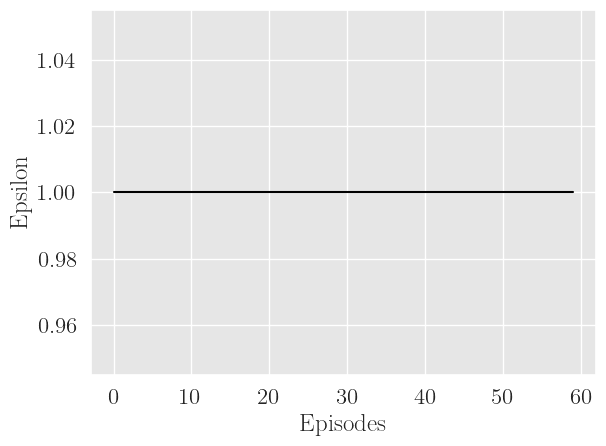

In [20]:
viz.plot_exploration_rate(epsilons, xlabel="Episodes")

## Training

In [21]:
Transition = namedtuple(
    "Transition", ("state", "action", "reward", "next_state", "done")
)

### Main loop

In [22]:
rewards = torch.zeros((p.total_episodes, p.n_runs), device=DEVICE)
steps = torch.zeros((p.total_episodes, p.n_runs), device=DEVICE)
episodes = torch.arange(p.total_episodes, device=DEVICE)
# all_states = []
all_actions = []
losses = [[] for _ in range(p.n_runs)]

for run in range(p.n_runs):  # Run several times to account for stochasticity
    # Reset everything
    net, target_net = neural_network()  # Reset weights
    optimizer = optim.AdamW(net.parameters(), lr=p.alpha, amsgrad=True)
    explorer = EpsilonGreedy(
        epsilon=p.epsilon_max,
        epsilon_min=p.epsilon_min,
        epsilon_max=p.epsilon_max,
        decay_rate=p.decay_rate,
        epsilon_warmup=p.epsilon_warmup,
    )
    weights_val_stats = None
    biases_val_stats = None
    weights_grad_stats = None
    biases_grad_stats = None
    replay_buffer = deque([], maxlen=p.replay_buffer_max_size)
    epsilons = []

    for episode in tqdm(
        episodes, desc=f"Run {run+1}/{p.n_runs} - Episodes", leave=False
    ):
        state = env.reset()  # Reset the environment
        state = state.clone().float().detach().to(DEVICE)
        step_count = 0
        done = False
        total_rewards = 0
        loss = torch.ones(1, device=DEVICE) * torch.nan

        while not done:
            state_action_values = net(state).to(DEVICE)  # Q(s_t)
            action = explorer.choose_action(
                action_space=env.action_space,
                state=state,
                state_action_values=state_action_values,
            ).item()

            # Record states and actions
            # all_states.append(state)
            # all_actions.append(Actions(action.item()).name)
            all_actions.append(Actions(action).name)

            next_state, reward, done = env.step(action=action, current_state=state)

            # Store transition in replay buffer
            # [current_state (2 or 28 x1), action (1x1), next_state (2 or 28 x1), reward (1x1), done (1x1 bool)]
            done = torch.tensor(done, device=DEVICE).unsqueeze(-1)
            replay_buffer.append(
                Transition(
                    state,
                    action,
                    reward,
                    next_state,
                    done,
                )
            )

            # Start training when `replay_buffer` is full
            if len(replay_buffer) == p.replay_buffer_max_size:
                transitions = utils.random_choice(
                    replay_buffer,
                    length=len(replay_buffer),
                    num_samples=p.batch_size,
                    generator=GENERATOR,
                )
                batch = Transition(*zip(*transitions, strict=True))
                state_batch = torch.stack(batch.state)
                action_batch = torch.tensor(batch.action, device=DEVICE)
                reward_batch = torch.cat(batch.reward)
                next_state_batch = torch.stack(batch.next_state)
                done_batch = torch.cat(batch.done)

                # See DQN paper for equations: https://doi.org/10.1038/nature14236
                state_action_values_sampled = net(state_batch).to(DEVICE)  # Q(s_t)
                state_action_values = torch.gather(
                    input=state_action_values_sampled,
                    dim=1,
                    index=action_batch.unsqueeze(-1),
                ).squeeze()  # Q(s_t, a)

                # done_false = torch.argwhere(done_batch == False).squeeze()
                # done_true = torch.argwhere(done_batch == True).squeeze()
                # expected_state_action_values = (
                #     torch.zeros_like(done_batch, device=DEVICE)
                # ).float()
                # with torch.no_grad():
                #     if done_true.numel() > 0:
                #         expected_state_action_values[done_true] = reward_batch[
                #             done_true
                #         ]
                #     if done_false.numel() > 0:
                #         next_state_values = (
                #             target_net(next_state_batch[done_false]).to(DEVICE).max(1)
                #         )  # Q(s_t+1, a)
                #         expected_state_action_values[done_false] = (
                #             reward_batch[done_false]
                #             + p.gamma * next_state_values.values
                #         )  # y_j (Bellman optimality equation)

                # Compute a mask of non-final states and concatenate the batch elements
                # (a final state would've been the one after which simulation ended)
                non_final_mask = torch.tensor(
                    tuple(map(lambda s: s == False, batch.done)),
                    device=DEVICE,
                    dtype=torch.bool,
                )
                non_final_next_states = torch.stack(
                    [s[1] for s in zip(batch.done, batch.next_state) if s[0] == False]
                )

                # Compute V(s_{t+1}) for all next states.
                # Expected values of actions for non_final_next_states are computed based
                # on the "older" target_net; selecting their best reward with max(1).values
                # This is merged based on the mask, such that we'll have either the expected
                # state value or 0 in case the state was final.
                next_state_values = torch.zeros(p.batch_size, device=DEVICE)
                if non_final_next_states.numel() > 0 and non_final_mask.numel() > 0:
                    with torch.no_grad():
                        next_state_values[non_final_mask] = (
                            target_net(non_final_next_states).max(1).values
                        )
                # Compute the expected Q values
                expected_state_action_values = reward_batch + (
                    next_state_values * p.gamma
                )

                # Compute loss
                # criterion = nn.MSELoss()
                criterion = nn.SmoothL1Loss()
                loss = criterion(
                    input=state_action_values,  # prediction
                    target=expected_state_action_values,  # target/"truth" value
                )  # TD update

                # Optimize the model
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_value_(
                    net.parameters(), 100
                )  # In-place gradient clipping
                optimizer.step()

                # # Reset the target network
                # if step_count % p.target_net_update == 0:
                #     target_net.load_state_dict(net.state_dict())

                # Soft update of the target network's weights
                # θ′ ← τ θ + (1 −τ )θ′
                target_net_state_dict = target_net.state_dict()
                net_state_dict = net.state_dict()
                for key in net_state_dict:
                    target_net_state_dict[key] = net_state_dict[
                        key
                    ] * p.tau + target_net_state_dict[key] * (1 - p.tau)
                target_net.load_state_dict(target_net_state_dict)

                losses[run].append(loss.item())

                weights, biases = utils.collect_weights_biases(net=net)
                weights_val_stats = utils.params_df_stats(
                    weights, key="val", current_df=weights_grad_stats
                )
                biases_val_stats = utils.params_df_stats(
                    biases, key="val", current_df=biases_val_stats
                )
                biases_grad_stats = utils.params_df_stats(
                    biases, key="grad", current_df=biases_grad_stats
                )
                weights_grad_stats = utils.params_df_stats(
                    weights, key="grad", current_df=weights_val_stats
                )

            total_rewards += reward
            step_count += 1

            # Move to the next state
            state = next_state

            explorer.epsilon = explorer.update_epsilon(episode)
            epsilons.append(explorer.epsilon)

        rewards[episode, run] = total_rewards
        steps[episode, run] = step_count
        LOGGER.info(
            f"Run: {run+1}/{p.n_runs} - Episode: {episode+1}/{p.total_episodes} - Steps: {step_count} - Loss: {loss.item()}"
        )
    weights_val_stats.set_index("Index", inplace=True)
    biases_val_stats.set_index("Index", inplace=True)
    biases_grad_stats.set_index("Index", inplace=True)
    weights_grad_stats.set_index("Index", inplace=True)

### Save data to disk

In [23]:
# data_path = CURRENT_PATH / "data.npz"
# with open(data_path, "wb") as fhd:
#     np.savez(
#         fhd,
#         rewards=rewards.cpu(),
#         steps=steps.cpu(),
#         episodes=episodes.cpu(),
#         all_actions=all_actions,
#         losses=losses,
#         p=p,
#     )

In [24]:
data_dict = {
    "rewards": rewards.cpu(),
    "steps": steps.cpu(),
    "episodes": episodes.cpu(),
    "all_actions": all_actions,
    "losses": losses,
    "p": p,
}

In [25]:
data_path = utils.save_data(data_dict=data_dict, current_path=CURRENT_PATH)

## Visualization

### Exploration rate

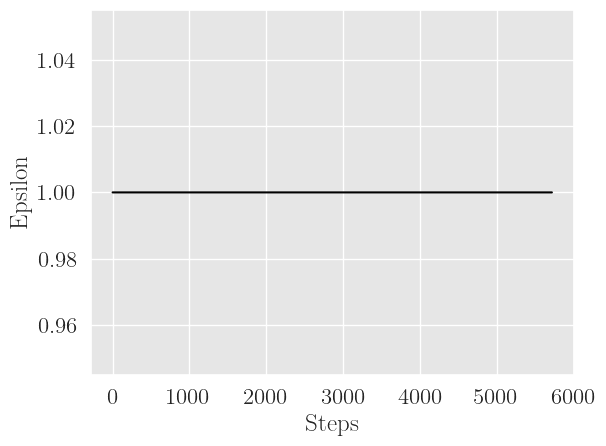

In [26]:
viz.plot_exploration_rate(epsilons, xlabel="Steps", figpath=CURRENT_PATH)

### States & actions distributions

In [27]:
rew_steps_df = utils.postprocess_rewards_steps(
    episodes=episodes, n_runs=p.n_runs, rewards=rewards, steps=steps
)
rew_steps_df

,Episodes,Rewards,Steps
0,0,0.0,145.0
1,1,1.0,120.0
2,2,1.0,277.0
3,3,1.0,52.0
4,4,0.0,49.0
5,5,1.0,62.0
6,6,1.0,94.0
7,7,1.0,58.0
8,8,0.0,177.0
9,9,0.0,28.0


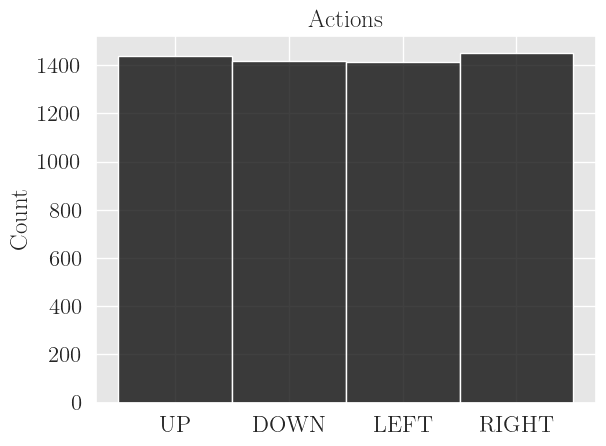

In [28]:
viz.plot_actions_distribution(all_actions, figpath=CURRENT_PATH)

### Steps & rewards

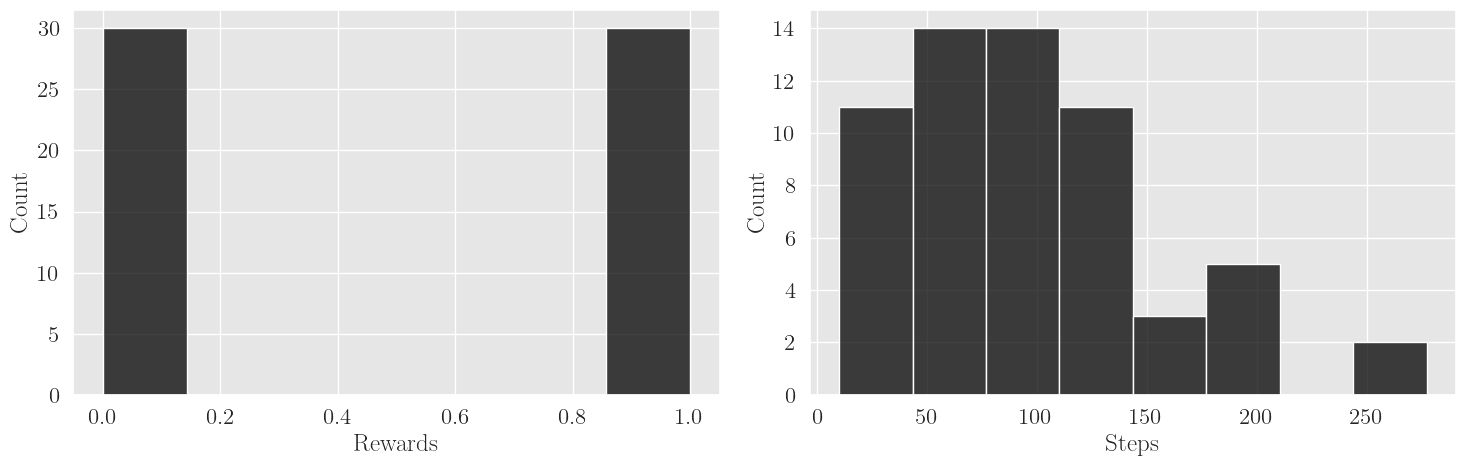

In [29]:
viz.plot_steps_and_rewards_dist(rew_steps_df, figpath=CURRENT_PATH)

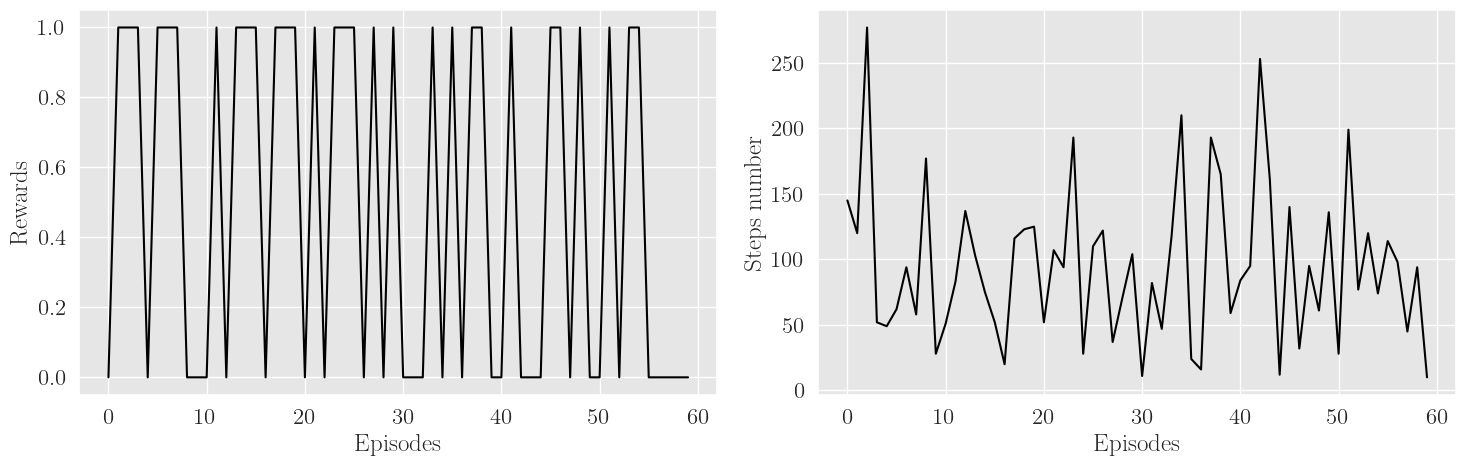

In [30]:
viz.plot_steps_and_rewards(rew_steps_df, n_runs=p.n_runs, figpath=CURRENT_PATH)

### Loss

In [31]:
loss_df = utils.postprocess_loss(losses=losses, window_size=1)
loss_df

,Run,Steps,Loss
0,0,0,0.008287
1,0,1,0.006724
2,0,2,0.006957
3,0,3,0.006269
4,0,4,0.005075
...,...,...,...
714,0,714,0.000026
715,0,715,0.000034
716,0,716,0.000048
717,0,717,0.000023


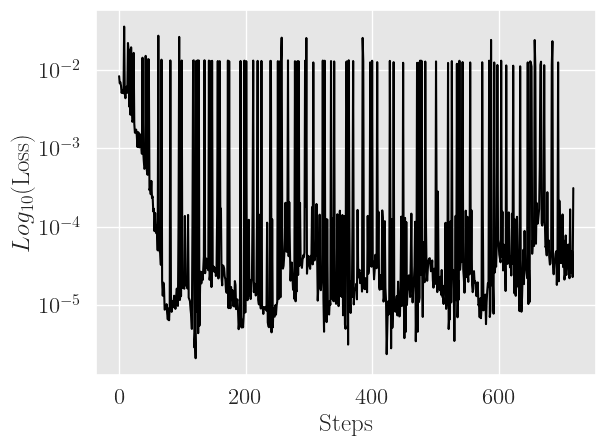

In [32]:
viz.plot_loss(loss_df, n_runs=p.n_runs, figpath=CURRENT_PATH)

### Policy learned

In [33]:
q_values = utils.get_q_values_by_states(
    env=env, cues=Cues, n_actions=p.n_actions, net=net
)
q_values.shape

torch.Size([25, 3, 4])

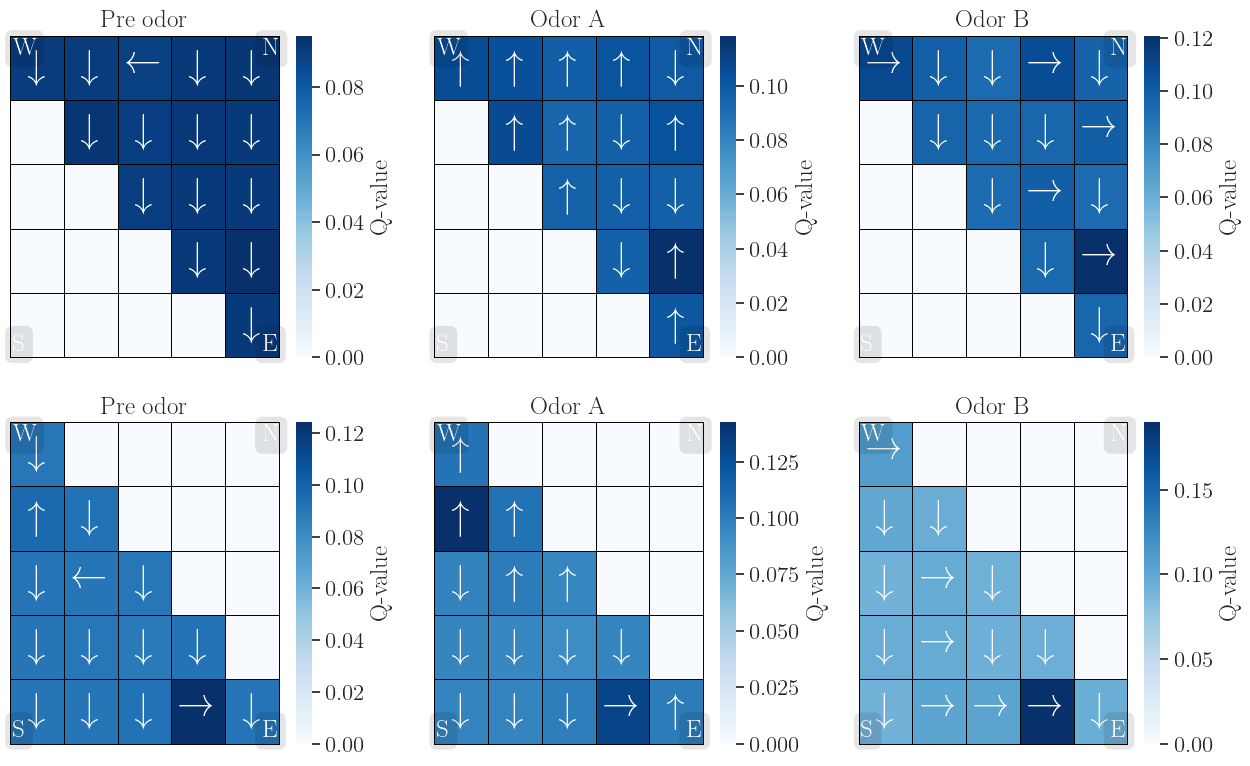

In [34]:
viz.plot_policies(
    q_values=q_values,
    labels=CONTEXTS_LABELS,
    n_rows=env.rows,
    n_cols=env.cols,
    figpath=CURRENT_PATH,
)

### Weights matrix

Plotting weights matrices...


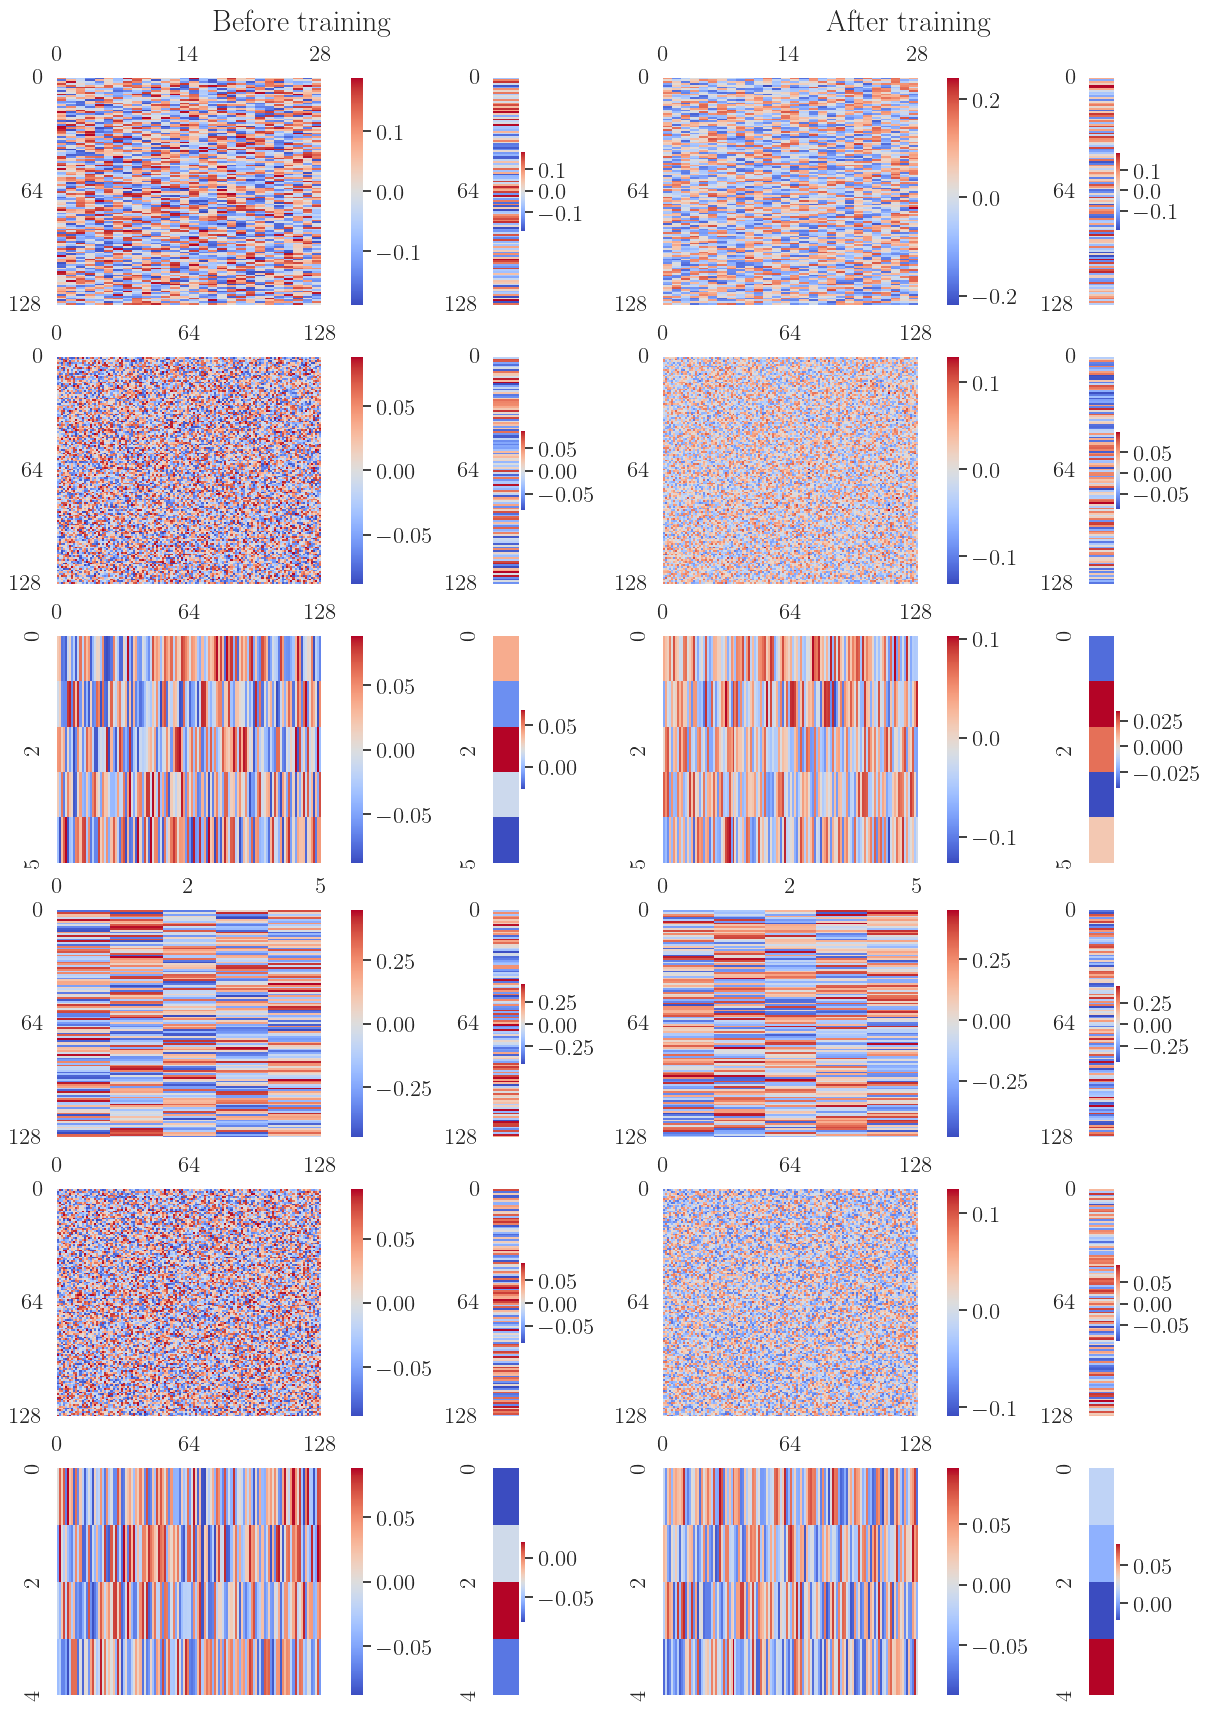

In [35]:
viz.plot_weights_matrices(
    weights_untrained=weights_untrained,
    weights_trained=[layer for layer in net.parameters()],
    figpath=CURRENT_PATH,
)

### Activations learned

In [36]:
# [item for item in net.mlp.named_children()]

In [37]:
# # Hook to capture the activations
# activations = {}


# def get_activation(name):
#     def hook(module, args, output):
#         activations[name] = output.detach()

#     return hook

In [38]:
# # Register the hooks for all layers
# for name, layer in net.mlp.named_children():
#     layer.register_forward_hook(get_activation(name))

In [39]:
# x = torch.randn(28)
# output = net(x)

In [40]:
# [val.shape for key, val in activations.items()]

In [41]:
# # Construct input dictionnary to be fed to the network
# input_cond = OrderedDict({})
# for cue_obj, cue_txt in CONTEXTS_LABELS.items():
#     for loc in env.state_space["location"]:
#         current_state = torch.tensor([loc, cue_obj.value], device=DEVICE)
#         if env.one_hot_state:
#             current_state = env.to_one_hot(current_state)
#         input_cond[f"{loc}-{cue_txt}"] = current_state.float()

In [42]:
# layer = list(net.mlp.children())[6]
# parameters = list(layer.named_parameters())
# weights = [params[1] for params in parameters if params[0] == "weight"][0]
# neurons_num = weights.shape[1]
# neurons_num

In [43]:
# # Get the activations from the network
# layer_inspected = 6 - 1
# activations_layer = (
#     torch.ones((len(input_cond), ENCODER_NEURONS_NUM), device=DEVICE) * torch.nan
# )
# for idx, (cond, input_val) in enumerate(input_cond.items()):
#     net(input_val)
#     activations_layer[idx, :] = activations[str(layer_inspected)]

In [44]:
# # cols = pd.MultiIndex.from_tuples(
# #     [("neuron", str(item)) for item in range(1, ENCODER_NEURONS_NUM + 1)]
# # )
# activations_layer_df = pd.DataFrame(activations_layer)  # , columns=cols)
# activations_layer_df["Input"] = list(input_cond.keys())
# activations_layer_df.set_index("Input", inplace=True)
# activations_layer_df

In [45]:
input_cond, activations_layer_df = utils.get_activations_learned(
    net=net, env=env, layer_inspected=p.layer_inspected, contexts_labels=CONTEXTS_LABELS
)

In [46]:
# input_cond

In [47]:
activations_layer_df

,0,1,2,3,4
Input,,,,,
0-Pre odor,0.058089,0.039267,0.0,0.0,0.000000
1-Pre odor,0.036931,0.041470,0.0,0.0,0.000000
2-Pre odor,0.046710,0.018820,0.0,0.0,0.000000
3-Pre odor,0.055837,0.050671,0.0,0.0,0.000000
4-Pre odor,0.078870,0.062167,0.0,0.0,0.000000
...,...,...,...,...,...
20-Odor B,0.124227,0.056279,0.0,0.0,0.000000
21-Odor B,0.118004,0.155686,0.0,0.0,0.000000
22-Odor B,0.124552,0.155798,0.0,0.0,0.000000


Plotting activations learned...


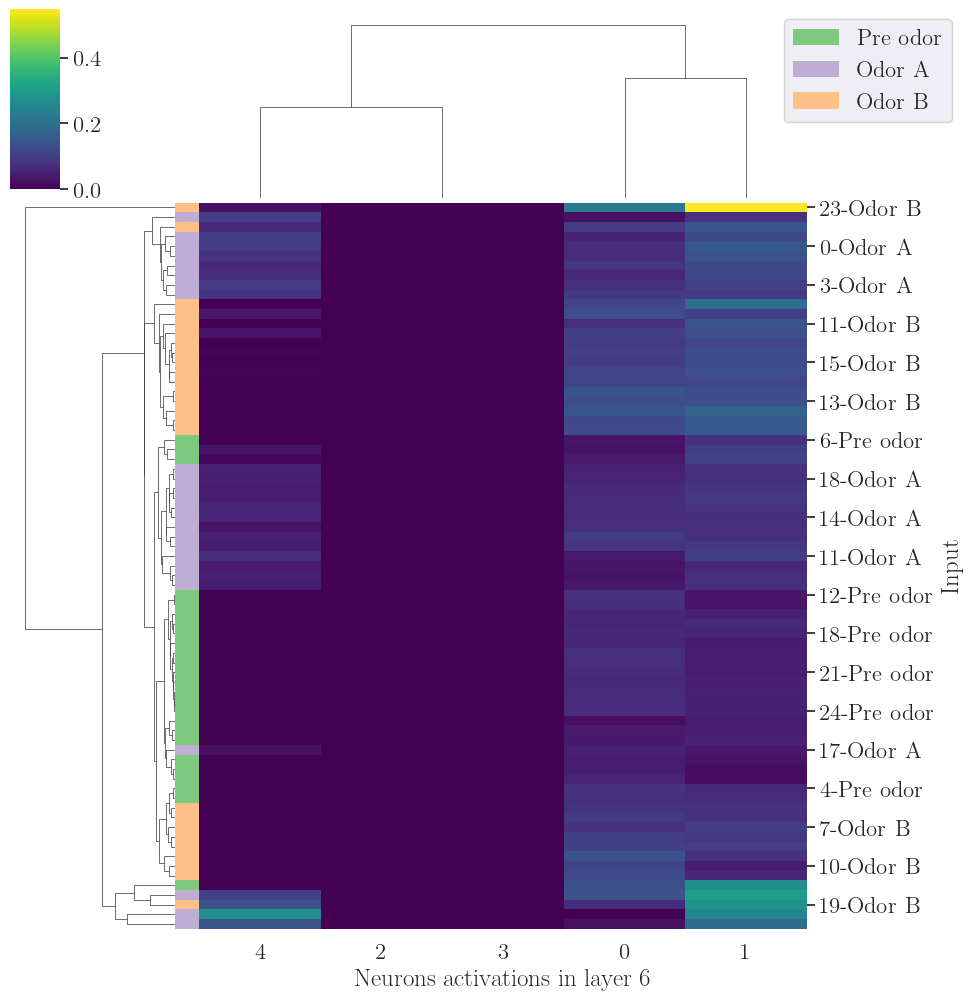

In [48]:
viz.plot_activations(
    activations_layer_df=activations_layer_df,
    input_cond=input_cond,
    labels=CONTEXTS_LABELS,
    layer_inspected=p.layer_inspected,
    figpath=CURRENT_PATH,
)

### Weights & gradients metrics

In [49]:
weights, biases = utils.collect_weights_biases(net=net)

In [50]:
weights_val_df = utils.postprocess_weights(weights["val"])
weights_val_df

,Val,Layer
0,0.132624,0
1,-0.146825,0
2,-0.043492,0
3,0.015153,0
4,-0.037658,0
...,...,...
507,0.029138,5
508,-0.047732,5
509,-0.070688,5
510,0.090086,5


In [51]:
weights_val_df.describe()

,Val,Layer
count,38144.000000,38144.000000
mean,0.000476,2.298658
std,0.067765,1.603728
min,-0.482014,0.000000
25%,-0.046642,1.000000
50%,0.000867,1.000000
75%,0.047314,4.000000
max,0.450941,5.000000


In [52]:
biases_val_df = utils.postprocess_weights(biases["val"])
biases_val_df

,Val,Layer
0,0.069053,0
1,-0.104309,0
2,0.071511,0
3,0.026700,0
4,0.183729,0
...,...,...
127,0.028908,4
0,0.018031,5
1,0.003728,5
2,-0.021882,5


In [53]:
biases_val_df.describe()

,Val,Layer
count,521.000000,521.000000
mean,0.002259,2.023033
std,0.145433,1.590672
min,-0.439650,0.000000
25%,-0.065228,1.000000
50%,0.012644,2.000000
75%,0.068152,4.000000
max,0.449601,5.000000


In [54]:
weights_grad_df = utils.postprocess_weights(weights["grad"])
weights_grad_df

,Val,Layer
0,0.000000,0
1,0.000000,0
2,-0.000002,0
3,0.000001,0
4,0.000000,0
...,...,...
507,0.000257,5
508,0.000000,5
509,0.000104,5
510,0.000051,5


In [55]:
weights_grad_df.describe()

,Val,Layer
count,3.814400e+04,38144.000000
mean,3.132214e-08,2.298658
std,2.384067e-05,1.603728
min,-4.683332e-04,0.000000
25%,0.000000e+00,1.000000
50%,0.000000e+00,1.000000
75%,1.173234e-07,4.000000
max,7.220530e-04,5.000000


In [56]:
biases_grad_df = utils.postprocess_weights(biases["grad"])
biases_grad_df

,Val,Layer
0,0.000030,0
1,0.000021,0
2,0.000009,0
3,-0.000004,0
4,0.000003,0
...,...,...
127,0.000000,4
0,-0.001863,5
1,0.000873,5
2,-0.000997,5


In [57]:
biases_grad_df.describe()

,Val,Layer
count,5.210000e+02,521.000000
mean,5.709847e-06,2.023033
std,1.500062e-04,1.590672
min,-1.863481e-03,0.000000
25%,-7.862700e-07,1.000000
50%,0.000000e+00,2.000000
75%,2.551689e-05,4.000000
max,1.958908e-03,5.000000


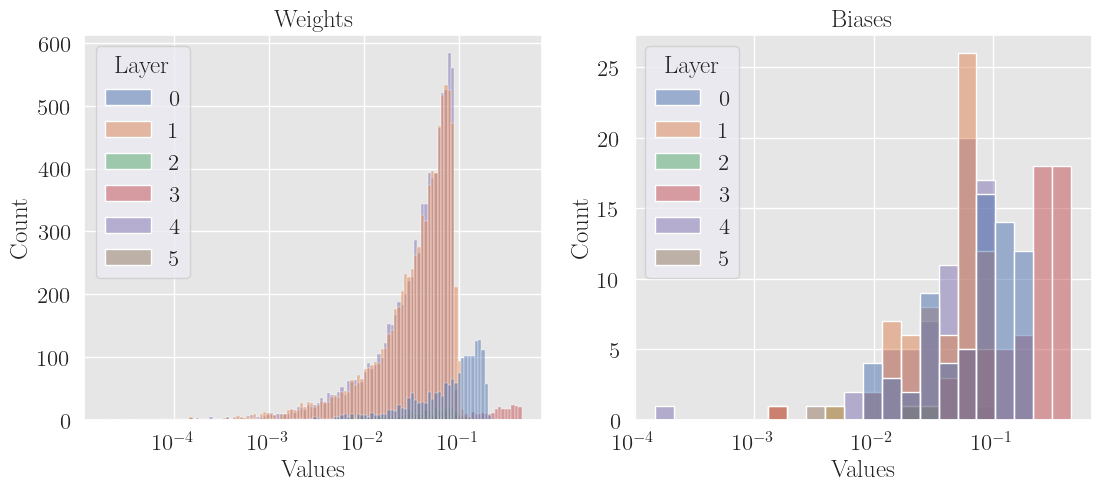

In [58]:
viz.plot_weights_biases_distributions(
    weights_val_df, biases_val_df, label="Values", figpath=CURRENT_PATH
)

In [59]:
assert utils.check_grad_stats(weights_grad_df), "Gradients are zero"

In [60]:
assert utils.check_grad_stats(biases_grad_df), "Gradients are zero"

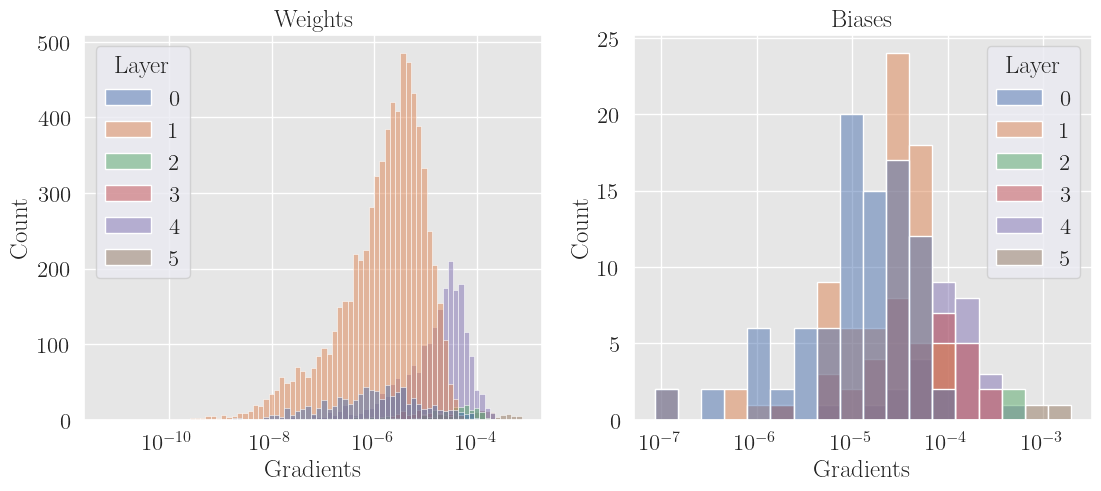

In [61]:
viz.plot_weights_biases_distributions(
    weights_grad_df, biases_grad_df, label="Gradients", figpath=CURRENT_PATH
)

In [62]:
weights_val_stats

,Std,Avg,Layer
Index,,,
0,0.109248,0.000255,0
1,0.050775,0.000411,1
2,0.051590,-0.001597,2
3,0.253820,0.005213,3
4,0.051021,0.000135,4
...,...,...,...
8617,0.051895,0.001190,1
8618,0.054475,0.000153,2
8619,0.254551,0.005699,3


In [63]:
biases_val_stats

,Std,Avg,Layer
Index,,,
0,0.105408,-0.003673,0
1,0.053959,0.001830,1
2,0.033427,-0.007015,2
3,0.264240,-0.006907,3
4,0.051946,0.008396,4
...,...,...,...
4309,0.054391,0.003674,1
4310,0.033508,-0.002467,2
4311,0.264144,-0.006270,3


In [64]:
weights_grad_stats

,Std,Avg,Layer
Index,,,
0,0.109248,2.552741e-04,0
1,0.050775,4.108939e-04,1
2,0.051590,-1.597143e-03,2
3,0.253820,5.213442e-03,3
4,0.051021,1.347395e-04,4
...,...,...,...
8623,0.000006,9.732099e-07,1
8624,0.000032,1.109705e-05,2
8625,0.000011,1.323589e-06,3


In [65]:
biases_grad_stats

,Std,Avg,Layer
Index,,,
0,0.000040,-0.000007,0
1,0.000133,-0.000009,1
2,0.001775,-0.000103,2
3,0.000988,0.000210,3
4,0.002192,0.000556,4
...,...,...,...
4309,0.000031,0.000012,1
4310,0.000239,0.000169,2
4311,0.000058,0.000007,3


In [66]:
viz.plot_weights_biases_stats(
    weights_val_stats, biases_val_stats, label="values", figpath=CURRENT_PATH
)

IndexError: index out of range

Error in callback <function _draw_all_if_interactive at 0x7fa2b8dbb1a0> (for post_execute):


IndexError: index out of range

IndexError: index out of range

<Figure size 1300x800 with 4 Axes>

In [ ]:
viz.plot_weights_biases_stats(
    weights_grad_stats, biases_grad_stats, label="gradients", figpath=CURRENT_PATH
)

In [ ]:
# weights_val_stats.rolling(10, center=True).mean().dropna()

In [ ]:
# rolling_win = 100
# plot_weights_biases_stats(
#     weights_val_stats.rolling(rolling_win, center=True).mean().dropna(),
#     biases_val_stats.rolling(rolling_win, center=True).mean().dropna(),
#     label="values",
# )

In [ ]:
# rolling_win = 100
# plot_weights_biases_stats(
#     weights_grad_stats.rolling(rolling_win, center=True).mean().dropna(),
#     biases_grad_stats.rolling(rolling_win, center=True).mean().dropna(),
#     label="values",
# )